In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier

In [3]:
train = pd.read_csv("flight-delays-fall-2018/flight_delays_train.csv.zip", compression='zip')
test = pd.read_csv("flight-delays-fall-2018/flight_delays_test.csv.zip", compression='zip')

In [6]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [5]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB
None


In [6]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB
None


In [7]:
train.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


In [4]:
all_data = pd.concat([train, test], ignore_index=True)
all_data.sample(15)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
105545,c-7,c-10,c-2,1217,OO,MRY,SFO,77,NaN
47260,c-7,c-28,c-5,2114,CO,IAH,LAX,1379,N
22004,c-2,c-14,c-2,728,XE,IAH,OKC,395,N
116034,c-12,c-30,c-7,1701,AS,SAN,SEA,1050,NaN
127296,c-9,c-16,c-7,1157,WN,DAL,ELP,562,NaN
74247,c-2,c-28,c-2,1837,UA,ORD,PIT,412,N
177081,c-7,c-2,c-1,829,OO,SLC,SEA,689,NaN
60836,c-11,c-20,c-1,830,MQ,DFW,SDF,733,N
5442,c-1,c-28,c-6,1250,WN,MCI,BWI,967,N
26655,c-5,c-31,c-3,1626,NW,RDU,DTW,501,N


In [5]:
# change target name to make it easier
train = train.rename(columns={'dep_delayed_15min':'delayed'})
all_data = all_data.rename(columns={'dep_delayed_15min':'delayed'})

In [6]:
# change target to numerical N-->0 & Y-->1
train.loc[(train.delayed == 'N'), 'delayed'] = 0
train.loc[(train.delayed == 'Y'), 'delayed'] = 1
all_data.loc[(all_data.delayed == 'N'), 'delayed'] = 0
all_data.loc[(all_data.delayed == 'Y'), 'delayed'] = 1

In [7]:
train['DayofMonth'] = train['DayofMonth'].str.split('-').str[1]
train['Month'] = train['Month'].str.split('-').str[1]
train['DayOfWeek'] = train['DayOfWeek'].str.split('-').str[1]

all_data['DayofMonth'] = all_data['DayofMonth'].str.split('-').str[1]
all_data['Month'] = all_data['Month'].str.split('-').str[1]
all_data['DayOfWeek'] = all_data['DayOfWeek'].str.split('-').str[1]

In [12]:
all_data

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,delayed
0,8,21,7,1934,AA,ATL,DFW,732,0
1,4,20,3,1548,US,PIT,MCO,834,0
2,9,2,5,1422,XE,RDU,CLE,416,0
3,11,25,6,1015,OO,DEN,MEM,872,0
4,10,7,6,1828,WN,MDW,OMA,423,1
...,...,...,...,...,...,...,...,...,...
199995,6,5,2,852,WN,CRP,HOU,187,NaN
199996,11,24,6,1446,UA,ORD,LAS,1515,NaN
199997,1,30,2,1509,OO,ORD,SGF,438,NaN
199998,1,5,5,804,DL,LGA,ATL,761,NaN


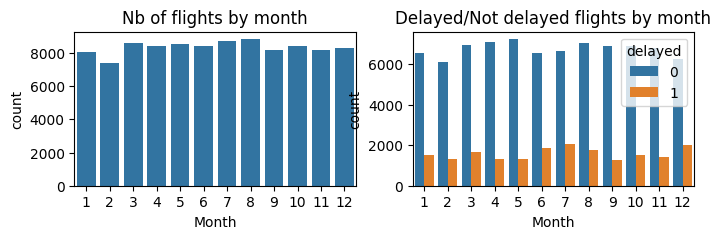

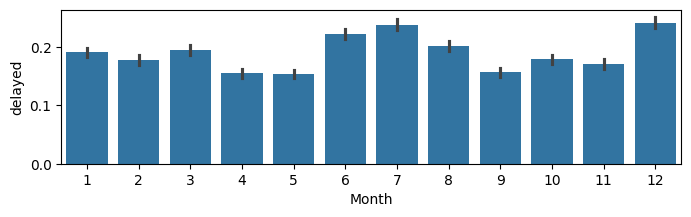

In [8]:
order = range(1, 13)
fig , ax = plt.subplots(1, 2, figsize=(8,2))
sns.countplot(data=train, x='Month', order=order, ax=ax[0])
ax[0].set_title('Nb of flights by month')
sns.countplot(data=train, x='Month', hue='delayed', order=order, ax=ax[1])
ax[1].set_title('Delayed/Not delayed flights by month')
plt.figure(figsize=(8,2))
sns.barplot(data=train, x = 'Month', y = 'delayed',order=order )

plt.show()

我们可以看到，所有月份的航班数量和延误数量几乎相同。不过，六月、七月和十二月的延迟率略高，可能是由于假期原因。

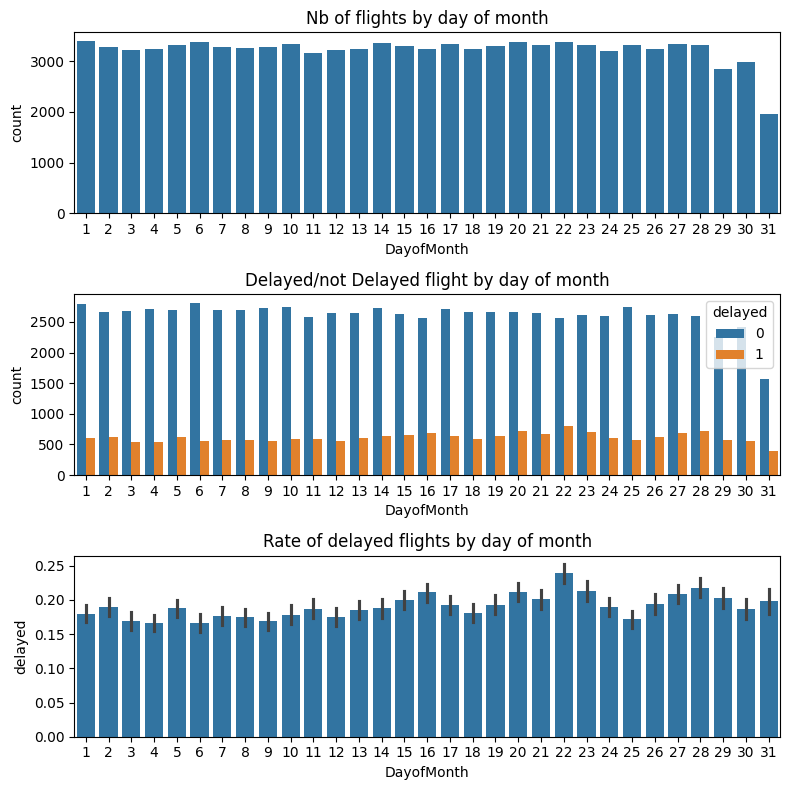

In [14]:
order = range(1, 32)

fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.countplot(x='DayofMonth', data=train, ax=ax[0],order=order)
ax[0].set_title('Nb of flights by day of month')
sns.countplot(x='DayofMonth', hue='delayed', data=train, ax=ax[1],order=order)
ax[1].set_title('Delayed/not Delayed flight by day of month')
sns.barplot(x='DayofMonth', y='delayed', data=train, ax=ax[2], order=order)
ax[2].set_title('Rate of delayed flights by day of month')

plt.tight_layout()
plt.show()

同样，很难说每个月的日子之间是否存在很大差异但是，我们可以说，在该月的最后几天，延迟率较高

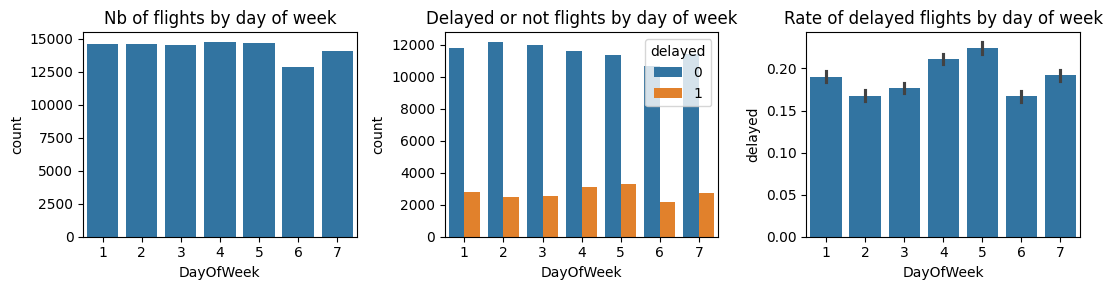

In [15]:
order = range(1,8)

fig, ax = plt.subplots(1, 3, figsize=(11,3))
sns.countplot(x='DayOfWeek', data=train, ax=ax[0],order=order)
ax[0].set_title('Nb of flights by day of week')
sns.countplot(x='DayOfWeek', hue='delayed', data=train, ax=ax[1],order=order)
ax[1].set_title('Delayed or not flights by day of week')
sns.barplot(x='DayOfWeek', y='delayed', data=train, ax=ax[2],order=order)   
ax[2].set_title('Rate of delayed flights by day of week')

plt.tight_layout()
plt.show()

在这里我们可以看到，周四和周五的航班延误率最高，而周二、周三和周六的航班延误率最低

Text(0.5, 0, 'Departure Time')

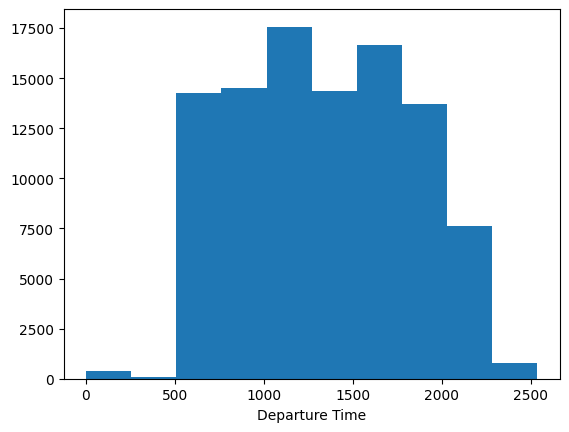

In [16]:
plt.hist(train.DepTime)
plt.xlabel('Departure Time')

由于值范围很大，一旦我们对它进行分类，我们就会回到这个变量

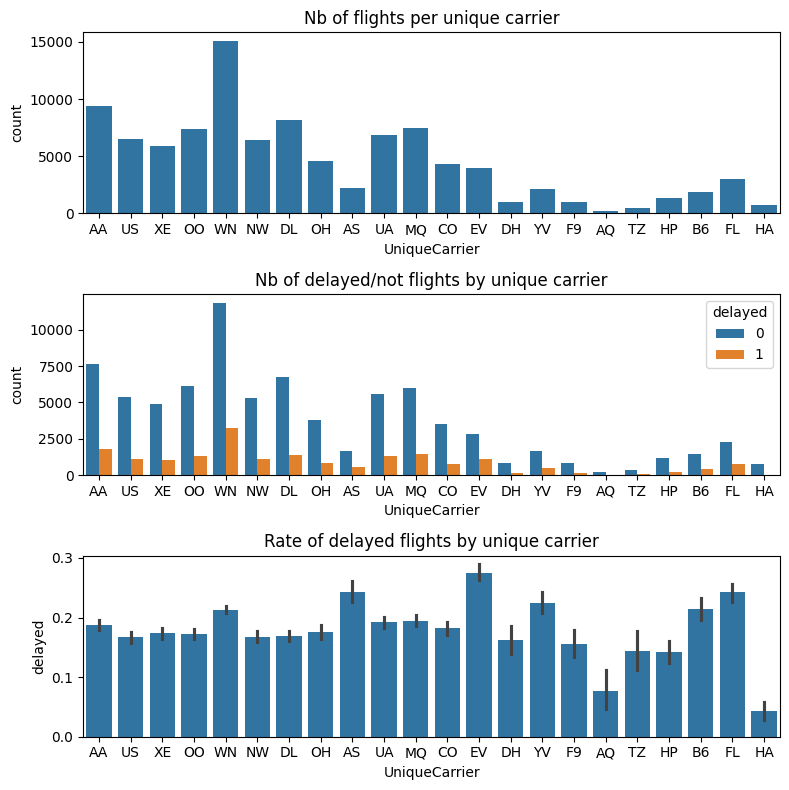

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.countplot(x='UniqueCarrier', data=train, ax=ax[0])
ax[0].set_title('Nb of flights per unique carrier')
sns.countplot(x='UniqueCarrier', hue='delayed', data=train, ax=ax[1])
ax[1].set_title('Nb of delayed/not flights by unique carrier')
sns.barplot(x='UniqueCarrier',y= 'delayed', data=train, ax=ax[2])
ax[2].set_title('Rate of delayed flights by unique carrier')

plt.tight_layout()
plt.show()

我们可以看到UniqueCarrier变量对于延迟有很好的作用

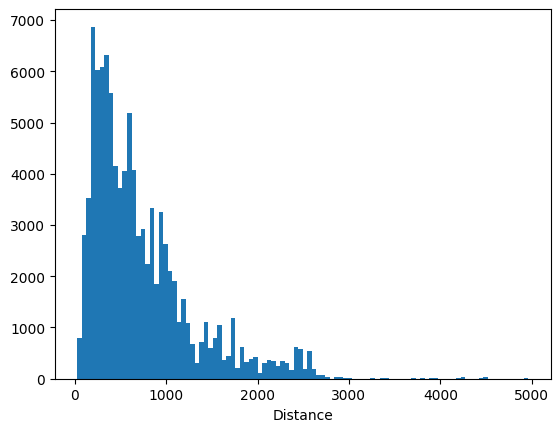

In [18]:
# 指定更多的分箱数量
plt.hist(train.Distance, bins=100)
plt.xlabel('Distance')
plt.show()

我们可以看到，，大多数航班的距离都很短，不到1000英里，标准化和/或缩放此变量是个好主意吗？或者这样差异是否更有意义？也许bin这个变量

In [19]:
all_data.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'delayed'],
      dtype='object')

In [9]:
all_data['Month'] = all_data['Month'].astype(int)
all_data['DayofMonth'] = all_data['DayofMonth'].astype(int)
all_data['DayOfWeek'] = all_data['DayOfWeek'].astype(int)
# 确保其他布尔列已经被转换为0和1
all_data.replace(to_replace=[False, True], value=[0, 1], inplace=True)

C:\Users\yaw\AppData\Local\Temp\ipykernel_7568\1656204714.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_data.replace(to_replace=[False, True], value=[0, 1], inplace=True)


In [21]:
all_data

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,delayed
0,8,21,7,1934,AA,ATL,DFW,732,0.0
1,4,20,3,1548,US,PIT,MCO,834,0.0
2,9,2,5,1422,XE,RDU,CLE,416,0.0
3,11,25,6,1015,OO,DEN,MEM,872,0.0
4,10,7,6,1828,WN,MDW,OMA,423,1.0
...,...,...,...,...,...,...,...,...,...
199995,6,5,2,852,WN,CRP,HOU,187,NaN
199996,11,24,6,1446,UA,ORD,LAS,1515,NaN
199997,1,30,2,1509,OO,ORD,SGF,438,NaN
199998,1,5,5,804,DL,LGA,ATL,761,NaN


In [10]:
all_data['flight'] = all_data['Origin'] + '->' + all_data['Dest']

In [11]:
from sklearn.preprocessing import LabelEncoder

# 将分类变量编码为数值变量
label_encoder = LabelEncoder()
all_data['UniqueCarrier'] = label_encoder.fit_transform(all_data['UniqueCarrier'])
all_data['Origin'] = label_encoder.fit_transform(all_data['Origin'])
all_data['Dest'] = label_encoder.fit_transform(all_data['Dest'])

all_data['flight'] = label_encoder.fit_transform(all_data['flight'])

In [24]:
all_data

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,delayed,flight
0,8,21,7,1934,1,19,82,732,0.0,171
1,4,20,3,1548,19,226,180,834,0.0,3986
2,9,2,5,1422,21,239,62,416,0.0,4091
3,11,25,6,1015,16,81,184,872,0.0,1304
4,10,7,6,1828,20,182,210,423,1.0,2979
...,...,...,...,...,...,...,...,...,...,...
199995,6,5,2,852,20,71,132,187,NaN,1002
199996,11,24,6,1446,18,213,159,1515,NaN,3635
199997,1,30,2,1509,16,213,260,438,NaN,3689
199998,1,5,5,804,7,166,19,761,NaN,2685


In [12]:
from sklearn.preprocessing import StandardScaler

# 初始化StandardScaler对象
scaler = StandardScaler()

# 提取distance和deptime列的数据，创建一个新数据框
to_scale = all_data[['Distance', 'DepTime']]

# 使用scaler对象对这两列数据进行标准化
scaled_data = scaler.fit_transform(to_scale)

# 将标准化后的数据转换回DataFrame并替换原有的列
all_data[['Distance', 'DepTime']] = pd.DataFrame(scaled_data, columns=['Distance', 'DepTime'])

# 检查标准化后的数据
print(all_data.head())


   Month  DayofMonth  DayOfWeek   DepTime  UniqueCarrier  Origin  Dest  \
0      8          21          7  1.240975              1      19    82   
1      4          20          3  0.434238             19     226   180   
2      9           2          5  0.170898             21     239    62   
3     11          25          6 -0.679729             16      81   184   
4     10           7          6  1.019436             20     182   210   

   Distance  delayed  flight  
0  0.010082      0.0     171  
1  0.189359      0.0    3986  
2 -0.545323      0.0    4091  
3  0.256148      0.0    1304  
4 -0.533019      1.0    2979  


In [13]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

C:\Users\yaw\AppData\Local\Temp\ipykernel_12180\1021493856.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[j], fit=norm, ax=ax[0][i])
C:\Users\yaw\AppData\Local\Temp\ipykernel_12180\1021493856.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[j], fit=norm, ax=ax[0][i])


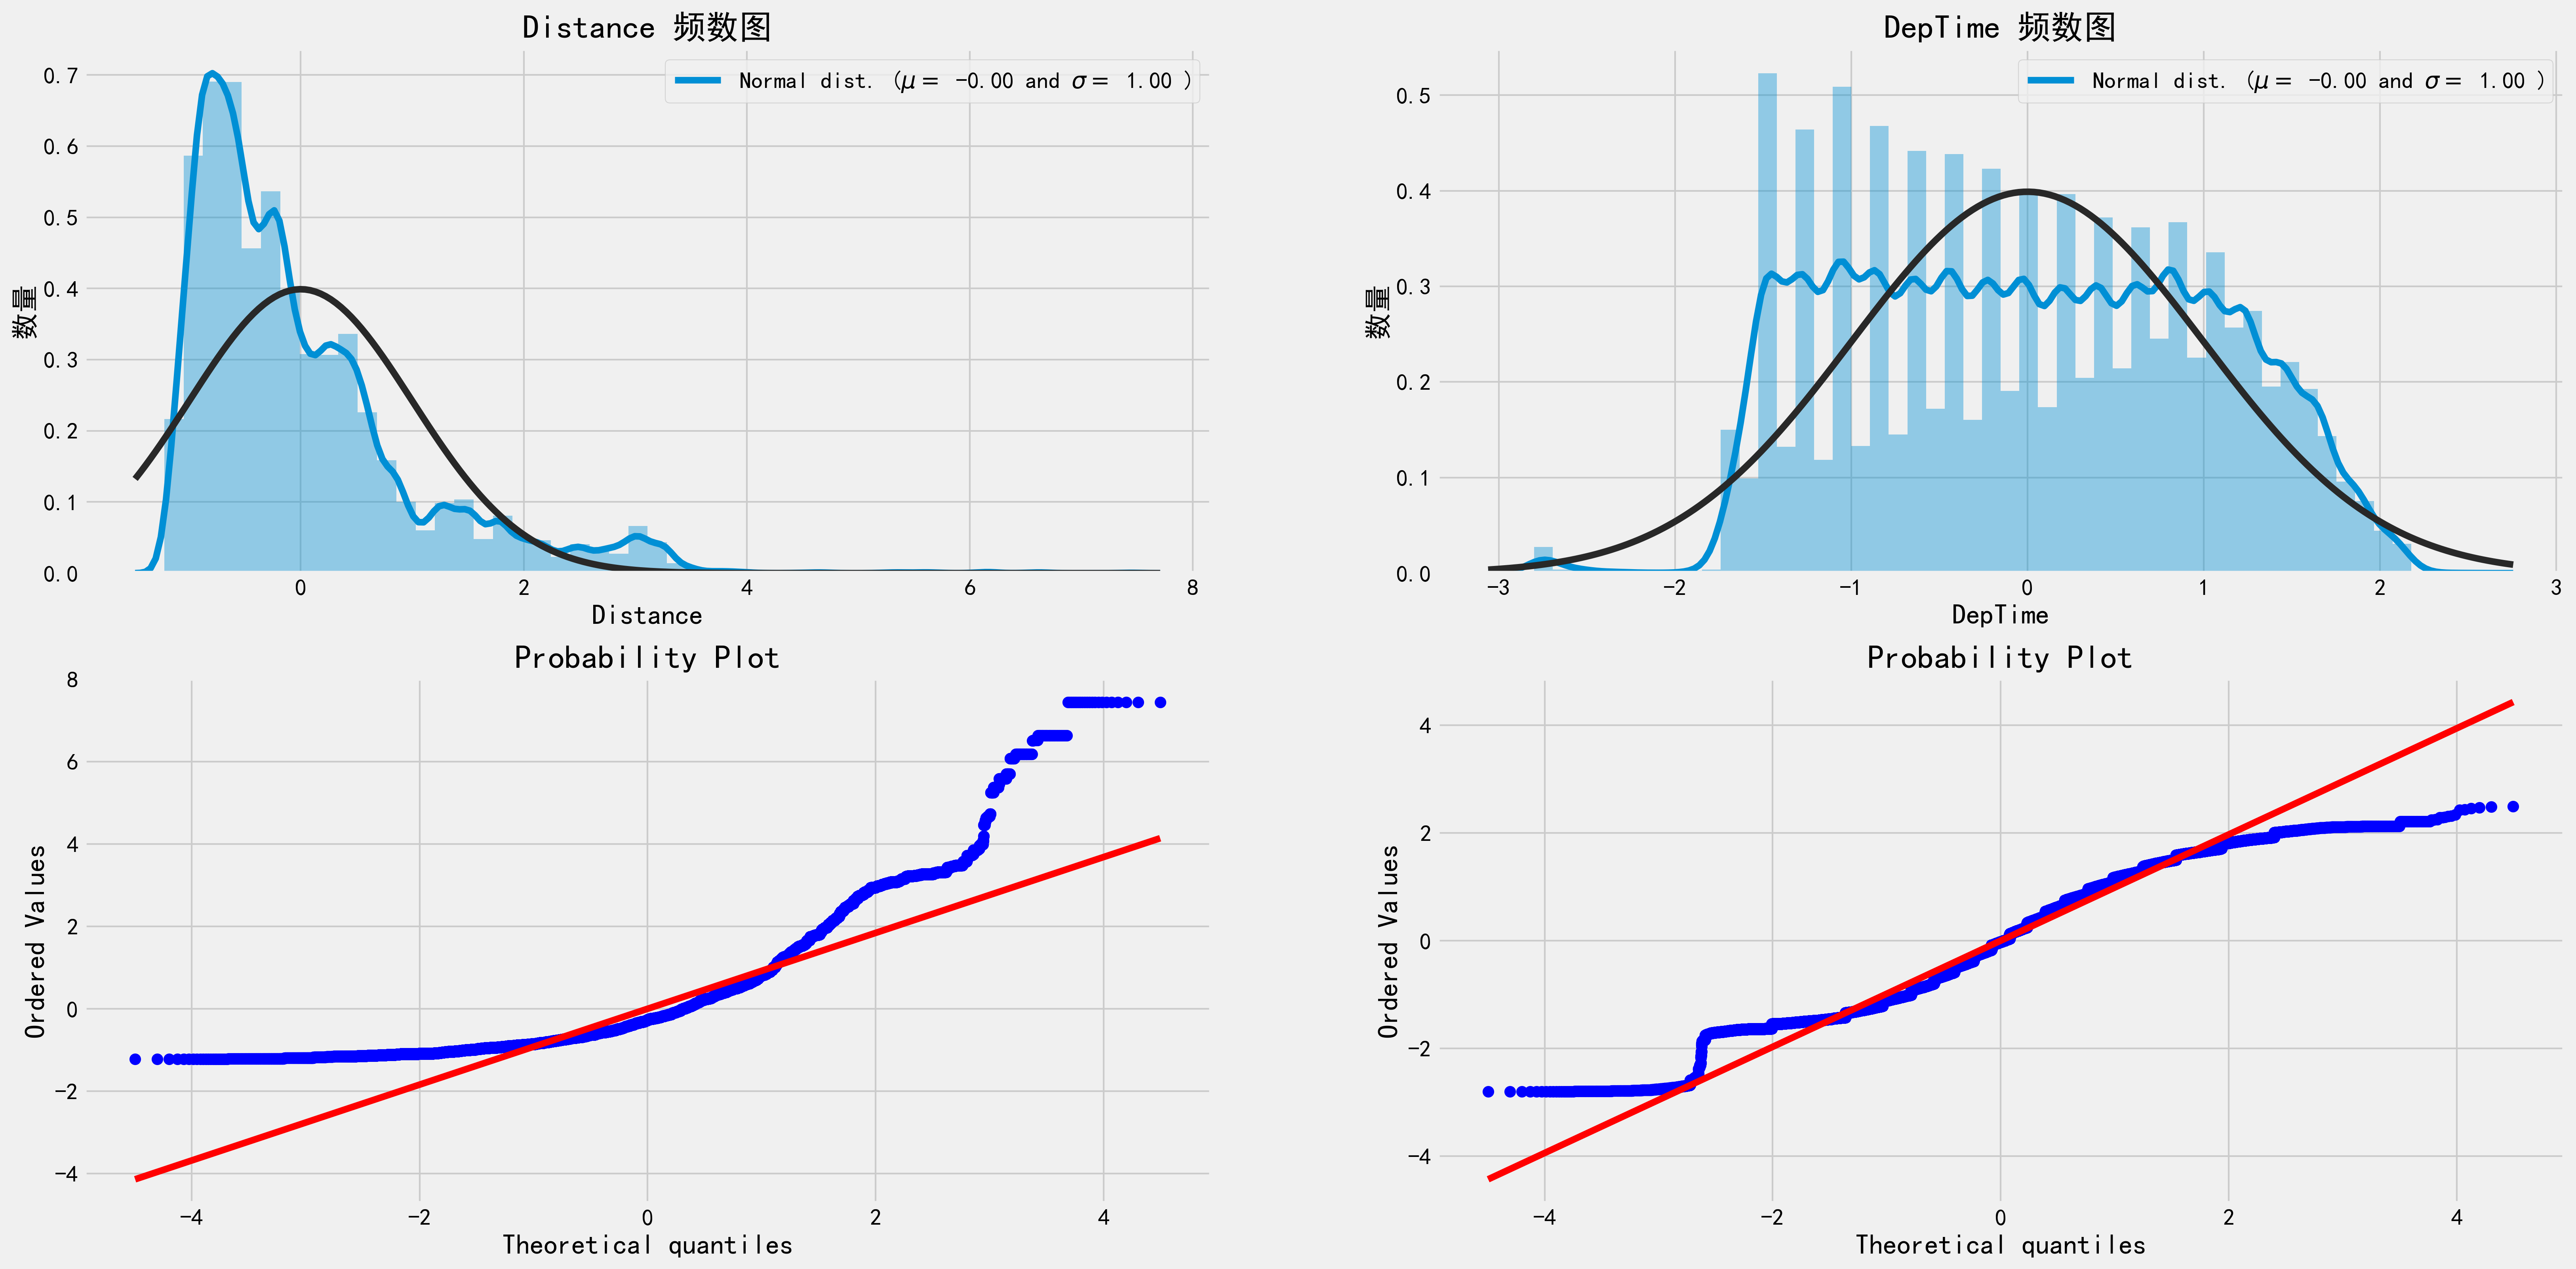

In [16]:
from scipy import stats
from scipy.stats import norm, skew 
plt.style.use('fivethirtyeight')    

def draw_dist_prob(data):    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24, 12), dpi=300)
    
    for i,j in enumerate(['Distance', 'DepTime']):
        sns.distplot(data[j], fit=norm, ax=ax[0][i])
        (mu, sigma) = norm.fit(data[j])
        ax[0][i].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
        ax[0][i].set_ylabel('数量')
        ax[0][i].set_title('{} 频数图'.format(j))
    
        stats.probplot(data[j], plot=ax[1][i])

draw_dist_prob(all_data)

In [14]:
new_train = all_data.iloc[:100000]
new_test = all_data.iloc[100000:]

In [15]:
pd.DataFrame([i for i in zip(new_train.columns,new_train.skew(),new_train.kurt())],
             columns=['特征','偏度','峰度'])

,特征,偏度,峰度
0,Month,-0.010479,-1.185646
1,DayofMonth,0.005243,-1.191204
2,DayOfWeek,0.038656,-1.226498
3,DepTime,0.046358,-0.971000
4,UniqueCarrier,-0.473497,-1.080771
5,Origin,-0.053754,-1.196075
6,Dest,-0.049907,-1.198262
7,Distance,1.657601,3.422551
8,delayed,1.576804,0.486321
9,flight,0.011166,-1.200668


In [19]:
print(new_train.columns)

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'delayed', 'flight'],
      dtype='object')


In [20]:
new_train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,delayed,flight
0,8,21,7,1.240975,1,19,82,0.010082,0.0,171
1,4,20,3,0.434238,19,226,180,0.189359,0.0,3986
2,9,2,5,0.170898,21,239,62,-0.545323,0.0,4091
3,11,25,6,-0.679729,16,81,184,0.256148,0.0,1304
4,10,7,6,1.019436,20,182,210,-0.533019,1.0,2979
...,...,...,...,...,...,...,...,...,...,...
99995,5,4,3,0.580537,16,259,237,-0.926724,0.0,4489
99996,1,18,3,-1.120718,5,98,76,0.277239,0.0,1696
99997,1,24,2,1.172006,14,88,139,0.614700,0.0,1556
99998,4,27,4,0.365268,13,82,114,-1.030423,0.0,1392


In [16]:
X = new_train.drop(columns=['delayed'])  # 特征
y = new_train['delayed']  # 目标变量

# 将数据拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

print("训练集样本数：", len(X_train))
print("测试集样本数：", len(X_test))

训练集样本数： 80000
测试集样本数： 20000


In [17]:
# 假设Graphviz的可执行文件路径是 /path/to/graphviz/bin
graphviz_path = r'C:/_program/Graphviz2.38/bin'

# 设置环境变量
import os
os.environ['PATH'] += os.pathsep + graphviz_path

## 逻辑回归

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [35]:
estimator = LogisticRegression(random_state=48)
estimator.fit(X_train, y_train)

c:\_program\miniconda3\envs\mining\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=48)

In [71]:
coefficients = estimator.coef_
intercept = estimator.intercept_

print(f'系数：{coefficients}')
print(f'截距：{intercept}')

系数：[[ 0.0053191  -0.00609726 -0.1148701   0.58579291 -0.01363056 -0.03954021
  -0.0018865  -0.01448655  0.00217832]]
截距：[-0.07433471]


In [69]:
from sklearn.metrics import recall_score

y_pred = estimator.predict(X_test)
print("Accuracy:", y_pred)

score = estimator.score(X_test, y_test)
print("Score:", score)

recall = recall_score(y_test, y_pred, average='macro')
print('Recall:', recall)

Accuracy: [0. 0. 0. ... 0. 0. 0.]
Score: 0.8083
Recall: 0.5068785896759784


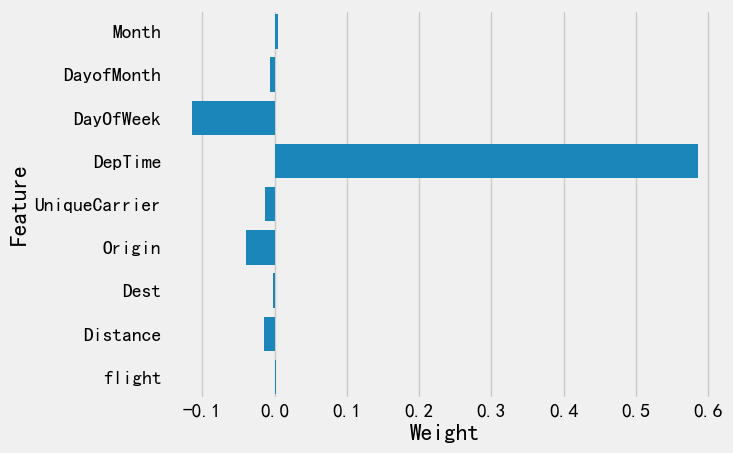

In [37]:
feature_names = X_train.columns 
weights = estimator.coef_[0]

# 绘制特征权重
import pandas as pd
import seaborn as sns

# 创建一个 DataFrame 来可视化
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights
})

# 绘制条形图
sns.barplot(x='Weight', y='Feature', data=feature_importance_df)
plt.show()

In [38]:
print(estimator.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 48, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [39]:
y_test = np.where(y_test > 0.5, 1, 0)
roc_auc_score(y_test, y_pred)

0.5068785896759784

## xgboost

In [41]:
from xgboost import XGBClassifier

XGBR_classifier = XGBClassifier(random_state=48)
XGBR_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=48, ...)

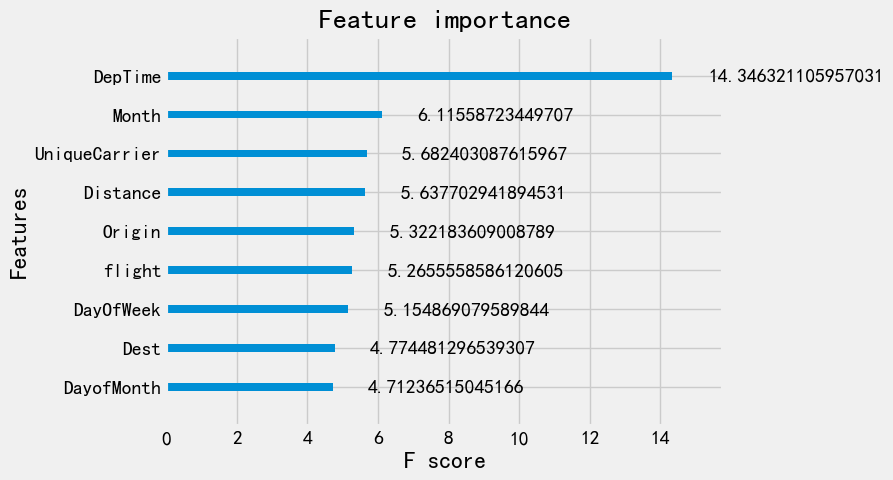

In [42]:
import xgboost as xgb
import matplotlib.pyplot as plt

y_pred = XGBR_classifier.predict(X_test)
xgb.plot_importance(XGBR_classifier, importance_type='gain')
plt.show()

In [44]:
plt.figure(figsize=(20, 10))
xgb.plot_tree(XGBR_classifier, num_trees=48)
plt.savefig("model/xgb.png", dpi=3000)  # 保存为 DPI 为 300 的图像
plt.close()

<Figure size 2000x1000 with 0 Axes>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score
import matplotlib

In [68]:
XGBR_classifier.fit(X_train, y_train)
xgb_y_pred = XGBR_classifier.predict(X_test)
print('xgboost混淆矩阵:',confusion_matrix(y_test,xgb_y_pred))
print('xgboostf1得分:',f1_score(y_test,xgb_y_pred))
rf_accuracy = accuracy_score(y_test, xgb_y_pred)
print("xgboost准确率：", rf_accuracy)
xgb_recall = recall_score(y_test, xgb_y_pred, average='macro')
print("xgboost 召回率：", xgb_recall)

xgboost混淆矩阵: [[15832   337]
 [ 3241   590]]
xgboostf1得分: 0.24800336275746113
xgboost准确率： 0.8211
xgboost 召回率： 0.5665822170448108


## 决策树

In [72]:
# 创建决策树模型
dtree = DecisionTreeClassifier()

# 训练模型
dtree.fit(X_train, y_train)
dt_y_pred = dtree.predict(X_test)
print('决策树混淆矩阵:',confusion_matrix(y_test,dt_y_pred))
print('决策树f1得分:',f1_score(y_test,dt_y_pred))
dt_accuracy = accuracy_score(y_test, dt_y_pred)
print("决策树准确率：", dt_accuracy)
dt_recall = recall_score(y_test, dt_y_pred, average='macro')
print("决策树召回率：", dt_recall)

决策树混淆矩阵: [[13374  2795]
 [ 2515  1316]]
决策树f1得分: 0.3314026693528079
决策树准确率： 0.7345
决策树召回率： 0.5853258970655472


In [46]:
import joblib
joblib.dump(dtree,'model/dt_classifier.pkl')

['model/dt_classifier.pkl']

In [73]:
from sklearn import tree
import graphviz

# 假设 dtree 是已经训练好的决策树模型

# 导出决策树为 dot 格式
dot_data = tree.export_graphviz(dtree,
                                 feature_names=X_train.columns.tolist(),
                                 class_names=np.unique(y_train).astype(str).tolist(),
                                 filled=True, rounded=True,
                                 special_characters=True)

# 将 dot 数据写入文件
with open("tree.dot", "w") as f:
    f.write(dot_data)

# 使用 Graphviz 的 dot 命令行工具来生成图像
# 您可以在命令行中运行以下命令来生成高分辨率的图像
# 例如，生成 DPI 为 300 的 PNG 图像：
os.system('dot -Tpng -o output_highres.png tree.dot -Gdpi=1300')

0

In [74]:
from sklearn.tree import export_graphviz
# 可视化随机森林中的第一棵树
dot_data = export_graphviz(dtree,
                                 feature_names=X_train.columns.tolist(),
                                 class_names=np.unique(y_train).astype(str).tolist(),
                                 filled=True, rounded=True,
                                 special_characters=True)

# 使用 graphviz 库将 DOT 数据转换为可视化图形
graph = graphviz.Source(dot_data)
graph.render("dtree")  # 会创建一个名为 "rf_tree.pdf" 的文件


from IPython.display import IFrame
IFrame('dtree.pdf', width='100%', height=400)

## 随机森林

In [54]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import  cross_val_score

# trainErr = []
# testErr = []
# CVErr = []
# K = np.arange(2, 15)

# for k in K:
#     modelRF = RandomForestRegressor(n_estimators=k, random_state=48)
#     modelRF.fit(X_train, y_train)
#     trainErr.append(1 - modelRF.score(X_train, y_train))
#     testErr.append(1 - modelRF.score(X_test, y_test))
#     Err = 1 - cross_val_score(modelRF, X, y, cv=5, scoring='r2')
#     CVErr.append(Err.mean())

# fig = plt.figure(figsize=(15, 6))
# ax1 = fig.add_subplot(121)
# ax1.grid(True, linestyle='-.')
# ax1.plot(K, trainErr, label="训练误差", marker='o', linestyle='-')
# ax1.plot(K, testErr, label="旁置法测试误差", marker='o', linestyle='-')
# ax1.plot(K, CVErr, label="5-折交叉验证误差", marker='o', linestyle='--')
# ax1.set_xlabel("树的数量")
# ax1.set_ylabel("误差（1-R方）")
# ax1.set_title('树的数量和误差')
# ax1.legend()

# plt.show()

In [66]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=48)

rf_classifier.fit(X_train, y_train)
rf_y_pred = rf_classifier.predict(X_test)

print('随机森林混淆矩阵：', confusion_matrix(y_test, rf_y_pred))
print('随机森林F1得分：', f1_score(y_test, rf_y_pred))
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print("随机森林准确率：", rf_accuracy)

rf_recall = recall_score(y_test, rf_y_pred, average='macro') 
print("随机森林召回率：", rf_recall)

随机森林混淆矩阵： [[15898   271]
 [ 3319   512]]
随机森林F1得分： 0.22193324664065886
随机森林准确率： 0.8205
随机森林召回率： 0.5584430499572359


In [55]:
from sklearn.tree import export_graphviz
# 可视化随机森林中的第一棵树
dot_data = export_graphviz(rf_classifier.estimators_[0], out_file=None, 
                           feature_names=X_train.columns,  # 假设 X_train.columns 包含了特征名称
                           class_names=rf_classifier.classes_.astype(str).tolist(),
                           filled=True, rounded=True, special_characters=True)

# 使用 graphviz 库将 DOT 数据转换为可视化图形
graph = graphviz.Source(dot_data)
graph.render("rf_tree")  # 会创建一个名为 "rf_tree.pdf" 的文件


from IPython.display import IFrame
IFrame('rf_tree.pdf', width='100%', height=400)

In [18]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

# 创建 CatBoost 模型
catboost_model = CatBoostClassifier(random_state=48)

# 准备数据，CatBoost 需要一个 Pool 对象
train_data = Pool(data=X, label=y)
test_data = Pool(data=X_test, label=y_test)

# 训练模型
catboost_model.fit(train_data, eval_set=test_data, plot=True)

# 预测
y_pred = catboost_model.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.098835
0:	learn: 0.6416162	test: 0.6417461	best: 0.6417461 (0)	total: 96.3ms	remaining: 1m 36s
1:	learn: 0.6008814	test: 0.6010479	best: 0.6010479 (1)	total: 109ms	remaining: 54.6s
2:	learn: 0.5706400	test: 0.5708960	best: 0.5708960 (2)	total: 121ms	remaining: 40.2s
3:	learn: 0.5464155	test: 0.5467963	best: 0.5467963 (3)	total: 133ms	remaining: 33.1s
4:	learn: 0.5271970	test: 0.5276511	best: 0.5276511 (4)	total: 144ms	remaining: 28.7s
5:	learn: 0.5114203	test: 0.5119247	best: 0.5119247 (5)	total: 155ms	remaining: 25.6s
6:	learn: 0.5006565	test: 0.5011557	best: 0.5011557 (6)	total: 166ms	remaining: 23.5s
7:	learn: 0.4914301	test: 0.4919162	best: 0.4919162 (7)	total: 178ms	remaining: 22s
8:	learn: 0.4824178	test: 0.4830555	best: 0.4830555 (8)	total: 190ms	remaining: 20.9s
9:	learn: 0.4756621	test: 0.4765048	best: 0.4765048 (9)	total: 202ms	remaining: 20s
10:	learn: 0.4709281	test: 0.4717678	best: 0.4717678 (10)	total: 213ms	remaining: 19.1s
11:	learn: 0.4655741	tes

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (10).

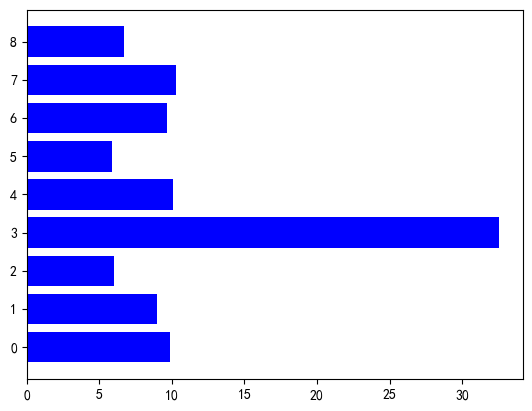

In [19]:
import catboost
import matplotlib.pyplot as plt

feature_importances = catboost_model.feature_importances_

import matplotlib.pyplot as plt

# 获取特征名称
feature_names = new_train.columns

# 绘制特征重要性
plt.barh(range(len(feature_importances)), feature_importances, color='blue')
plt.yticks(range(len(feature_importances)), feature_names)
plt.show()

In [27]:
new_train.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'delayed', 'flight'],
      dtype='object')

In [28]:
# 评估模型
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
print('CatBoost 混淆矩阵:',confusion_matrix(y_test,y_pred))
print('CatBoost f1得分:',f1_score(y_test,y_pred))
catboost_accuracy = accuracy_score(y_test, y_pred)
print("CatBoost 准确率：", catboost_accuracy)
print("CatBoost 召回率", recall_score(y_test, y_pred, average='macro'))

CatBoost 混淆矩阵: [[16052   117]
 [ 3035   796]]
CatBoost f1得分: 0.33558178752107926
CatBoost 准确率： 0.8424
CatBoost 召回率 0.600271289425826


In [20]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV

# 假设X_train, y_train是训练数据和标签
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=48)

# 定义超参数搜索空间
param_space = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'depth': (3, 5),
    'l2_leaf_reg': (1, 3),
}

# 初始化CatBoost模型
model = CatBoostClassifier(random_seed=48)

# 使用BayesSearchCV进行超参数优化
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=50,  
    cv=5,       
    n_jobs=-1,  
    verbose=0
)

# 拟合贝叶斯优化模型
bayes_search.fit(X_train, y_train, eval_set=(X_val, y_val))

# 最佳参数
best_params = bayes_search.best_params_
print("Best parameters found: ", best_params)

# 使用最佳参数训练模型
best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=20)

0:	learn: 0.6307959	test: 0.6309713	best: 0.6309713 (0)	total: 18.2ms	remaining: 18.2s
1:	learn: 0.5856315	test: 0.5860791	best: 0.5860791 (1)	total: 34.9ms	remaining: 17.4s
2:	learn: 0.5522380	test: 0.5527015	best: 0.5527015 (2)	total: 50ms	remaining: 16.6s
3:	learn: 0.5295731	test: 0.5300117	best: 0.5300117 (3)	total: 64.2ms	remaining: 16s
4:	learn: 0.5107011	test: 0.5114440	best: 0.5114440 (4)	total: 80.4ms	remaining: 16s
5:	learn: 0.4962290	test: 0.4972043	best: 0.4972043 (5)	total: 94.7ms	remaining: 15.7s
6:	learn: 0.4858597	test: 0.4869209	best: 0.4869209 (6)	total: 110ms	remaining: 15.6s
7:	learn: 0.4769974	test: 0.4784885	best: 0.4784885 (7)	total: 125ms	remaining: 15.5s
8:	learn: 0.4702907	test: 0.4717829	best: 0.4717829 (8)	total: 142ms	remaining: 15.6s
9:	learn: 0.4650038	test: 0.4666623	best: 0.4666623 (9)	total: 157ms	remaining: 15.6s
10:	learn: 0.4616192	test: 0.4635690	best: 0.4635690 (10)	total: 174ms	remaining: 15.6s
11:	learn: 0.4587031	test: 0.4608004	best: 0.4608004

In [21]:
best_model.get_feature_importance()

array([ 9.64964815,  8.29930187,  5.44579416, 38.80372063,  9.58641907,
        5.3109646 ,  7.79935831,  8.87269281,  6.23210039])

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 假设X_val, y_val是验证集数据和标签
y_pred_val = best_model.predict(X_val)

# 评估指标
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val)
recall = recall_score(y_val, y_pred_val, average='macro')
f1 = f1_score(y_val, y_pred_val)
roc_auc = roc_auc_score(y_val, y_pred_val)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {roc_auc}")

Accuracy: 0.8227
Precision: 0.703281027104137
Recall: 0.5579114520909955
F1 Score: 0.2175639894086496
AUC-ROC: 0.5579114520909954


In [81]:
sample = pd.read_csv("flight-delays-fall-2018/sample_submission.csv.zip", compression='zip')
sample.head(900)

,id,dep_delayed_15min
0,0,0.081
1,1,0.387
2,2,0.069
3,3,0.177
4,4,0.732
...,...,...
895,895,0.310
896,896,0.573
897,897,0.414
898,898,0.002


In [82]:
predictions = catboost_model.predict_proba(new_test)[:, 1]

submission = pd.DataFrame({'id':range(100000),'dep_delayed_15min':predictions})
submission.head(900)

,id,dep_delayed_15min
0,0,0.015381
1,1,0.048662
2,2,0.050985
3,3,0.237203
4,4,0.178453
...,...,...
895,895,0.177044
896,896,0.035716
897,897,0.225661
898,898,0.146988


In [83]:
filename = 'flight_delay.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: flight_delay.csv


In [110]:
import joblib
joblib.dump(catboost_model,'model/catboost_classifier.pkl')

['model/catboost_classifier.pkl']